<a href="https://colab.research.google.com/github/meysamalishahi/ReinforcementLearning/blob/master/Chapter%206/SARSA_and_Q_Learning_Racetrack_Exercise_5_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 5.12: Racetrack (programming) 
Consider driving a race car around a turn like those shown in Figure 5.5. You want to go as fast as possible, but not so fast as to run off the track. In our simplified racetrack, the car is at one of a discrete set of grid positions, the cells in the diagram. The velocity is also discrete, a number of grid cells moved horizontally and vertically per time step. The actions are increments to the velocity components. Each may be changed by $+1$, $-1$, or $0$ in each step, for a total of nine ($3 \times 3$) actions. Both velocity components are restricted to be nonnegative and less than $5$, and they cannot both be zero except at the starting line. Each episode begins in one of the randomly selected start states with both velocity components zero and ends when the car crosses the finish line. The rewards are $-1$ for each step until the car crosses the finish line. If the car hits the track boundary, it is moved back to a random position on the starting line, both velocity components are reduced to zero, and the episode continues. Before updating the car's location at each time step, check to see if the projected path of the car intersects the track boundary. If it intersects the finish line, the episode ends; if it intersects anywhere else, the car is considered to have hit the track boundary and is sent back to the starting line. To make the task more challenging, with probability $0.1$ at each time step the velocity increments are both zero, independently of the intended increments. Apply a Monte Carlo control method to this task to compute the optimal policy from each starting state. Exhibit several trajectories following the optimal policy (but turn the noise off for these trajectories).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import time

%matplotlib inline
from mpl_toolkits import mplot3d
from itertools import product 
from termcolor import colored
from matplotlib import colors

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
Turn_A_matrix = np.array([
    [0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3],
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
]).astype(int)

In [3]:
Turn_B_matrix = np.array([
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3],     
    [0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3],     
    [0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3], 
    [0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3], 
    [0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3], 
    [0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3], 
    [0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3], 
    [0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3], 
    [0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3], 
    [0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3],     
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0], 
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0], 
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0], 
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0], 
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],    
    [0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],    
    [0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],    
    [0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],    
    [0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],   
    [0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],     
    [0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],     
    [0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],     
    [0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],    
    [0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],    
    [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],
    [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0],    
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0],
]).astype(int)

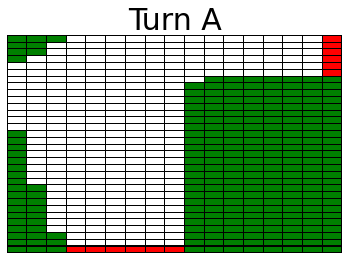

In [4]:
cmap = colors.ListedColormap(['black','green','red','white','red'])
bounds=[-1.5, -0.5, 0.5, 1.5, 2.5, 3.5]
norm = colors.BoundaryNorm(bounds, cmap.N)
fig = sns.heatmap(Turn_A_matrix, cmap=cmap, annot=False, 
                  linewidth=0.05, linecolor ='black', xticklabels=False, 
                  yticklabels=False, norm = norm, cbar= False)

fig.set_title("Turn A", fontsize=30)

#YlGnBu
plt.show()
plt.close()

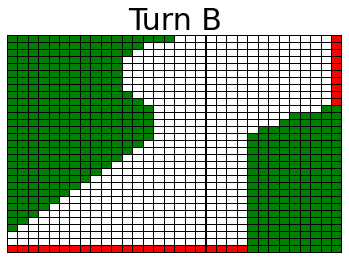

In [5]:
#plt.subplots(figsize=(10,10))
fig = sns.heatmap(Turn_B_matrix, cmap=cmap, annot=False, 
                  linewidth=0.05, linecolor ='black', xticklabels=False, 
                  yticklabels=False, norm = norm, cbar= False)

fig.set_title("Turn B", fontsize=30)

#YlGnBu
plt.show()
plt.close()

In [6]:
def set_start_finish_positions(Matrix):
    A = np.where(Matrix==1)
    B = np.where(Matrix==3)
    start_positions = list(zip(A[0], A[1]))
    finish_positions = list(zip(B[0], B[1]))
    return start_positions, finish_positions

In [7]:
def set_states(Matrix):
    A = np.where(((Matrix == 2) + (Matrix == 1) + (Matrix == 3)) == True)
    states = [(A[0][i], A[1][i], y, x) for i in range(len(A[0])) 
              for y in range(min_vy, max_vy+1) for x in range(min_vx, max_vx+1)]
    return states

In [8]:
def start():
    start_position = start_positions[np.random.choice(len(start_positions))]
    x, y = start_position
    return (x, y, 0, 0)

In [9]:
def possible_actions(state):
    _, _, y, x = state
    possible_row_actions = [i for i in [-1, 0, 1] if y+i >= min_vy and y+i <= max_vy]
    possible_column_actions = [i for i in [-1, 0, 1] if i+x >= min_vx and i+x <= max_vx]
    Actions = [(i,j) for i in possible_row_actions
              for j in possible_column_actions if y+i != 0 or x+j != 0]
    probabilities = [1/len(Actions) for _ in Actions]
    return [Actions , probabilities]

In [10]:
def is_valid_position(m, n, Matrix):
    if m < 0:
        return False
    if n < 0:
        return False
    
    try:
        if Matrix[m,n] == 0:
            return False
        else: 
            return True
    except:
        return False

In [11]:
def RacetrackEnv(state, action, noise = True):

    # Making the task more challenging!!
    if noise and np.random.uniform() < 0.1:
        return state, -1, False
        
    x, y, a, b = state
    u, v = action 
    if (u>1 or u<-1 or
        v>1 or v<-1 or
        a+u > max_vy or a+u < min_vy or 
        b+v > max_vx or b+v < min_vx or 
        (a+u == 0 and b+v == 0)):
        
        raise Exception("The action %s is not allowed for the state %s" %(action, state))
        
    if is_valid_position(x -(a+u), y+b+v, Turn_Matrix):
        return (x -(a+u), y+b+v, a+u, b+v), -1, False
    elif cross_finish_line(state, action):
        return None, 0, True  
    else:
        return start(), -1, False

In [12]:
def cross_finish_line(state, action):
    x_0, y_0, u, v = state
    a, b = action
    
    x_1, y_1 = x_0-(u+a), y_0+v+b

    m_0, n_0 = finish_positions[0]
    m_1, n_1 = finish_positions[-1]
   
    det = (x_1-x_0)*(n_0-n_1) - (y_1-y_0)*(m_0-m_1)
    if det == 0:
        return False
    t = (1/det) *( (n_0-n_1)*(m_0-x_0) + (m_1-m_0)*(n_0-y_0) )
    s = (1/det) *( (y_0-y_1)*(m_0-x_0) + (x_1-x_0)*(n_0-y_0) )
    
    if 0<=s<=1 and 0<t<1:
        return True
    return False

In [13]:
def BehaiviarPolicy(Matrix): 
    states = set_states(Matrix) 
    behaiviar_policy = {}
    for s in states:
        behaiviar_policy[s] = possible_actions(s) 
    return behaiviar_policy

In [14]:
class Racetrack:

    def __init__(self, n_iters, Matrix, Type = 'Sarsa', gamma = 1, 
                 eps = .1, alpha = .1, n_steps = 1, figsize = (20,30)):

        self.behaiviar_policy = BehaiviarPolicy(Matrix)
        self.target_policy = {}
        self.states = set_states(Matrix)
        self.Q = {}
        
        for s in self.states:
            self.Q[s] = {}
            for a in self.behaiviar_policy[s][0]:              
                self.Q[s][a] = 0 
                
        
        sum_episodes_length = 0
        st = 1
        for x in range(1, n_iters+1):
            
            if x == 1:
                t1 = t = time.time()
                print(colored('Starting iteration number:', 'blue'), 1)
            elif (x-1)% 50000 == 0:
                print(colored('Average lenth of episodes for iterations in [%s ... %s]:' %(st, x-1), 'red'), 
                      sum_episodes_length/(x-st), '\n',
                      colored('epsilon:', 'red'), eps, '\n',
                      colored('done in:', 'red'), time.time()-t1, 
                      colored('seconds', 'red'), '\n')
                
                t1 = time.time()
                st = x
                sum_episodes_length = 0
            
                print(colored('Starting iteration number:', 'blue'), x) 

####################################################################################################
####################################################################################################  
            cnt = 0            
            current_state = start()
            Done = False
            SARSAlist = []
            G = 0
            reward = 0
            while len(SARSAlist) < n_steps and not Done:
                
                current_action = self.apply_behaiviar_policy(current_state)
                next_state, reward, Done = RacetrackEnv(current_state, current_action)
                SARSAlist.append((current_state, current_action, reward))
                G += gamma**(cnt) * reward
                current_state = next_state
                cnt += 1
                sum_episodes_length += 1

            while  len(SARSAlist) > 0:                              
                s, a, r = SARSAlist.pop(0)
                if not Done:
                    cnt += 1
                    current_action = self.apply_behaiviar_policy(current_state)
                    next_state, reward, Done = RacetrackEnv(current_state, current_action)
                    SARSAlist.append((current_state, current_action, reward))
                    if Type == 'Sarsa':
                        temp = G + gamma**n_steps * self.Q[current_state][current_action]
                    elif Type == 'Q-learning':
                        temp = G + gamma**n_steps * max(self.Q[current_state].values())
                    elif Type == 'Expected-Sarsa':
                        temp = G + gamma**n_steps * self.expected_sarsa(current_state)
                    else:
                        raise Exception("Unknown Type!! Valid types are: Sarsa, Q-learning, and Expected-Sarsa.")

                    #temp = G + gamma**n_steps * self.Q[current_state][current_action]
                    current_state = next_state
                    G = (G-r)/gamma + gamma**(n_steps-1) * reward
                    sum_episodes_length += 1
                else:
                    temp = G
                    G = (G-r)/gamma

                self.Q[s][a] = self.Q[s][a] + alpha * (temp - self.Q[s][a])
                  
                self.update_behaiviar_policy(eps, state = s)
            #print('len of episode %s is %s' %(x,cnt))
        
        
####################################################################################################
####################################################################################################
                      
        
        print(colored('Ended in %s seconds', 'white', 'on_grey') %(time.time() - t))
        self.get_target_policy()
        self.plot_target_policy(Matrix, figsize)   


    def expected_sarsa(self, state):
        A = self.behaiviar_policy[state][0]
        P = self.behaiviar_policy[state][1] 
        mu = 0
        for i, a in enumerate(A):
            mu += P[i]*self.Q[state][a]
        return mu
    
    def build_episode(self):    
        next_state = start()
        Done = False
        episode = []
        actions = []
        rewards = []
        while not Done:
            episode.append(next_state)
            next_action = self.apply_behaiviar_policy(next_state)
            actions.append(next_action)
            next_state, reward, Done = RacetrackEnv(next_state, next_action)
            rewards.append(reward)
        return episode, actions, rewards  
    
    
    def apply_behaiviar_policy(self, state):
        possibleactaions = self.behaiviar_policy[state][0]
        probabilities = self.behaiviar_policy[state][1]
        index = np.random.choice(range(len(possibleactaions)), p = probabilities)
        next_action = possibleactaions[index]
        return next_action
        

    def update_behaiviar_policy(self, eps, state = None):
        
        if state is None:
            States = self.states
        else:
            States = [state]
            
        for s in States:
            Max = max(self.Q[s].values())
            possibleactaions = self.behaiviar_policy[s][0]
            index = np.random.choice([x for x in range(len(possibleactaions))
                                      if self.Q[s][possibleactaions[x]] >= Max-1e-10])
                    
            best_action = possibleactaions[index]
            for idx in range(len(possibleactaions)):
                if best_action == possibleactaions[idx]:
                    self.behaiviar_policy[s][1][idx] = 1 - eps + eps/len(possibleactaions)
                else:
                    self.behaiviar_policy[s][1][idx] = eps/len(possibleactaions)
            
    def bulid_trajectory(self, position):
        trajectory = []
        path = []
        Done = False
        reward = 0
        a,b = position
        state = (a,b,0,0)
        while not Done:
            trajectory.append(position)
            path.append(state)
            idx = np.argmax(self.behaiviar_policy[state][1])
            action = self.behaiviar_policy[state][0][idx]
            state, r, Done = RacetrackEnv(state, action, noise = False)
            
            if state is not None:
                a,b,_,_= state
                position = (a,b)
                reward += r            
        return trajectory, reward, path
    
    
    def get_target_policy(self):
        for state in self.behaiviar_policy.keys():
            idx = np.argmax(self.behaiviar_policy[state][1])
            action = self.behaiviar_policy[state][0][idx]
            self.target_policy[state] = action


    def plot_target_policy(self, Matrix, figsize):
        plt.subplots(figsize=figsize)
        for idx, start_point in enumerate(start_positions):
            counter = 0
            temp_matrix = Matrix.copy()
            TR = self.bulid_trajectory(start_point)
            for i,point in enumerate(TR[0]):
                counter 
                temp_matrix[point[0], point[1]] = -i-1
            show_annot_array = temp_matrix < 0
            cmap = colors.ListedColormap(['black','green','red','white','red'])
            bounds=[-100, -0.5, 0.5, 1.5, 2.5, 3.5]
            norm = colors.BoundaryNorm(bounds, cmap.N)
            
            plt.subplot(len(start_positions)//3 +1, 3, idx+1)
            fig = sns.heatmap(temp_matrix, cmap=cmap, annot=True, 
                              linewidth=0.05, linecolor ='black', xticklabels=False, 
                              yticklabels=False, norm = norm, cbar= False, square = False )
            fig.set_title("Policy; start point: " + str(start_point), fontsize=15)

            for text, show_annot in zip(fig.texts, (element for row in show_annot_array for element in row)):
                text.set_visible(show_annot)


        plt.show()
        plt.close()

## Set setting for Turn A

In [15]:
Turn_Matrix = Turn_A_matrix
start_positions, finish_positions = set_start_finish_positions(Turn_Matrix)

min_vx = -4
max_vx = 4

min_vy = 0
max_vy = 4

# SARSA

Starting iteration number: 1
Average lenth of episodes for iterations in [1 ... 50000]: 36.0162 
 epsilon: 0.2 
 done in: 156.8037986755371 seconds 

Starting iteration number: 50001
Ended in 245.48731422424316 seconds


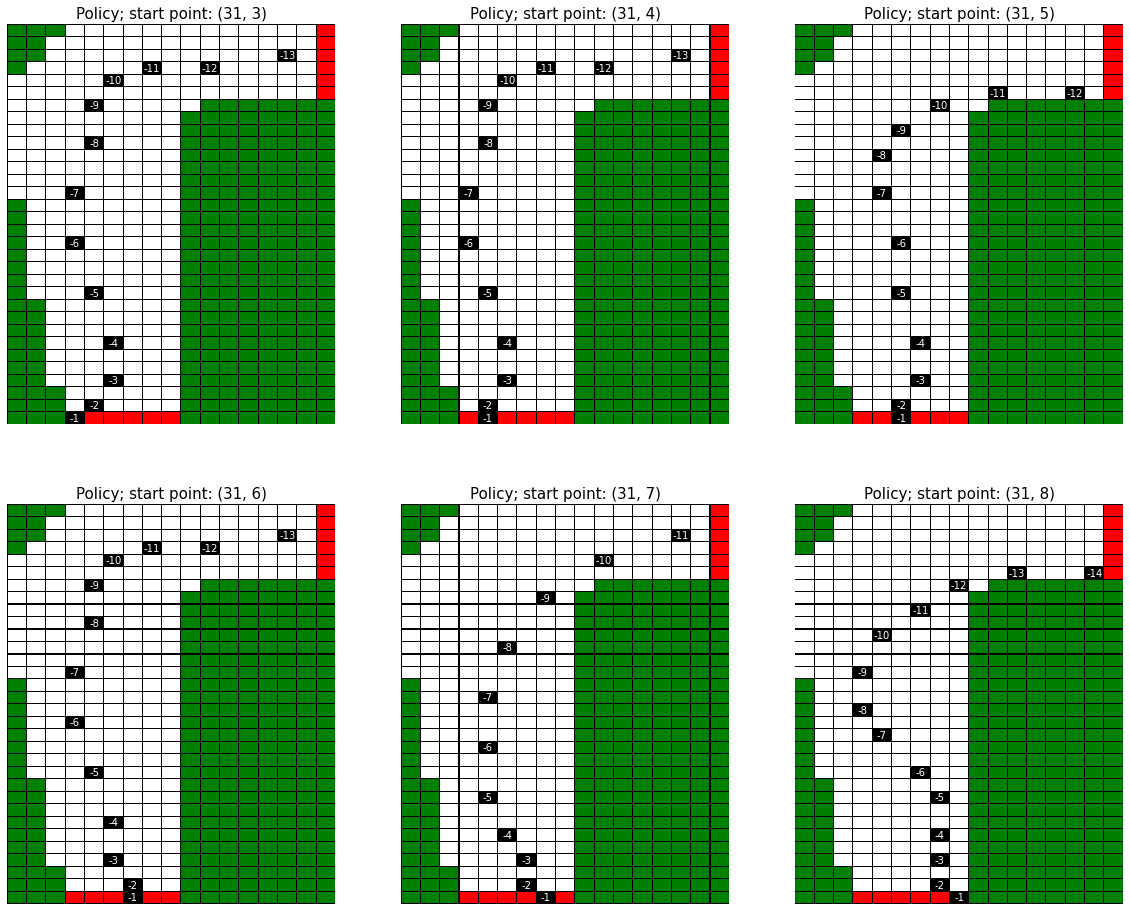

In [16]:
TD = Racetrack(100000, Turn_Matrix, Type= 'Sarsa', gamma = .99, alpha = .1, 
               eps = .2, n_steps = 3, figsize = (20,25))

# Q-Learning

Starting iteration number: 1
Average lenth of episodes for iterations in [1 ... 50000]: 34.06358 
 epsilon: 0.2 
 done in: 142.1170139312744 seconds 

Starting iteration number: 50001
Ended in 224.4720175266266 seconds


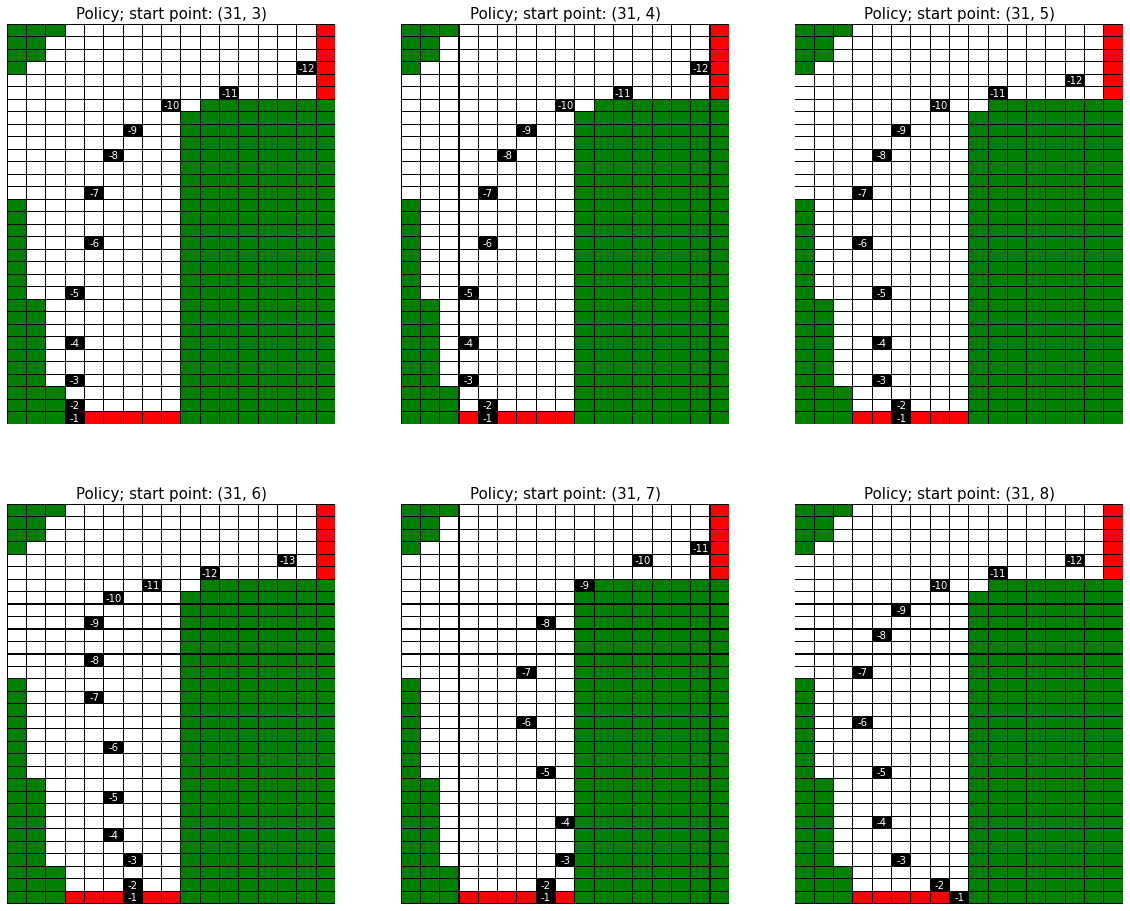

In [17]:
TD = Racetrack(100000, Turn_Matrix, Type= 'Q-learning', gamma = .99, alpha = .1, 
               eps = .2, n_steps = 3, figsize = (20,25))

# Expected Sarsa

Starting iteration number: 1
Average lenth of episodes for iterations in [1 ... 50000]: 34.68292 
 epsilon: 0.2 
 done in: 163.2567412853241 seconds 

Starting iteration number: 50001
Ended in 255.59564018249512 seconds


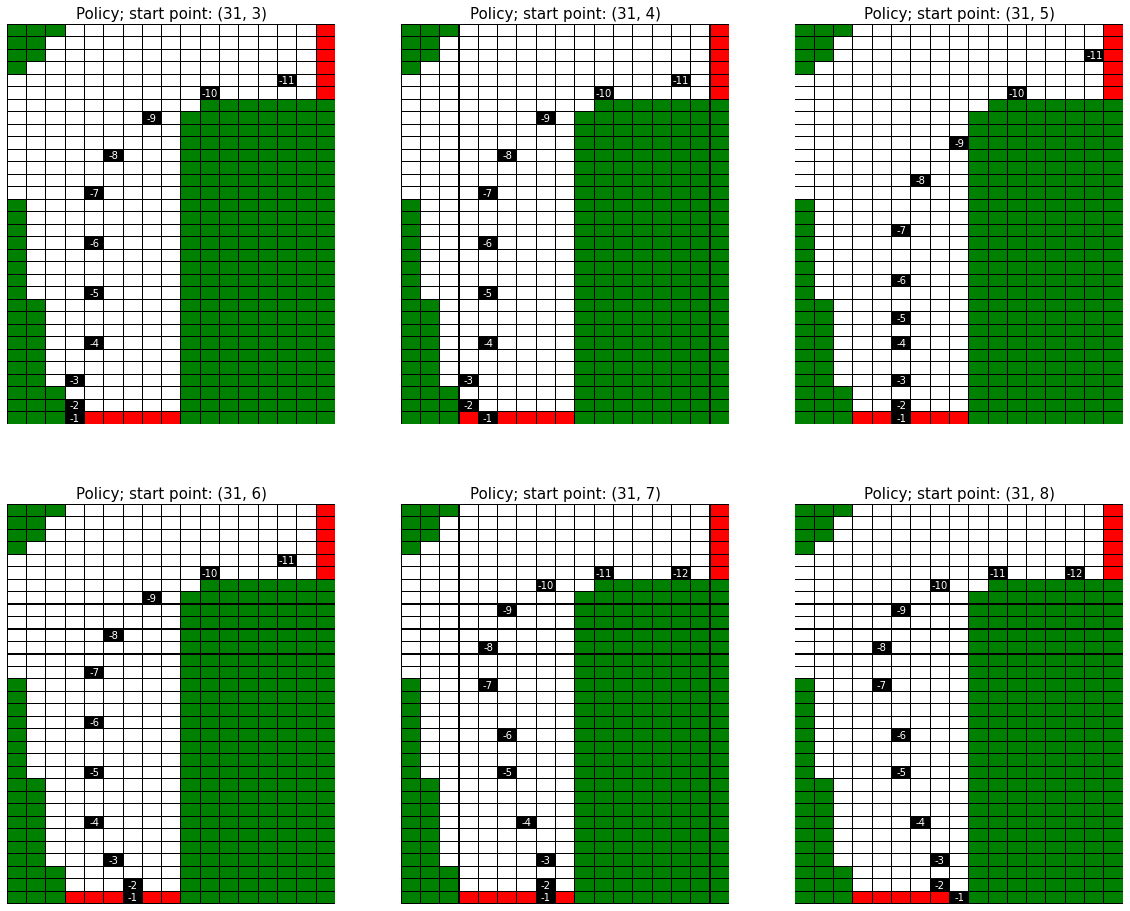

In [18]:
TD = Racetrack(100000, Turn_Matrix, Type= 'Expected-Sarsa', gamma = .99, alpha = .1, 
               eps = .2, n_steps = 3, figsize = (20,25))

## Set setting for Turn B

In [19]:
Turn_Matrix = Turn_B_matrix
start_positions, finish_positions = set_start_finish_positions(Turn_Matrix)

min_vx = -4
max_vx = 4

min_vy = 0
max_vy = 4

# SARSA

Starting iteration number: 1
Average lenth of episodes for iterations in [1 ... 50000]: 35.14118 
 epsilon: 0.2 
 done in: 144.89119482040405 seconds 

Starting iteration number: 50001
Ended in 206.8034703731537 seconds


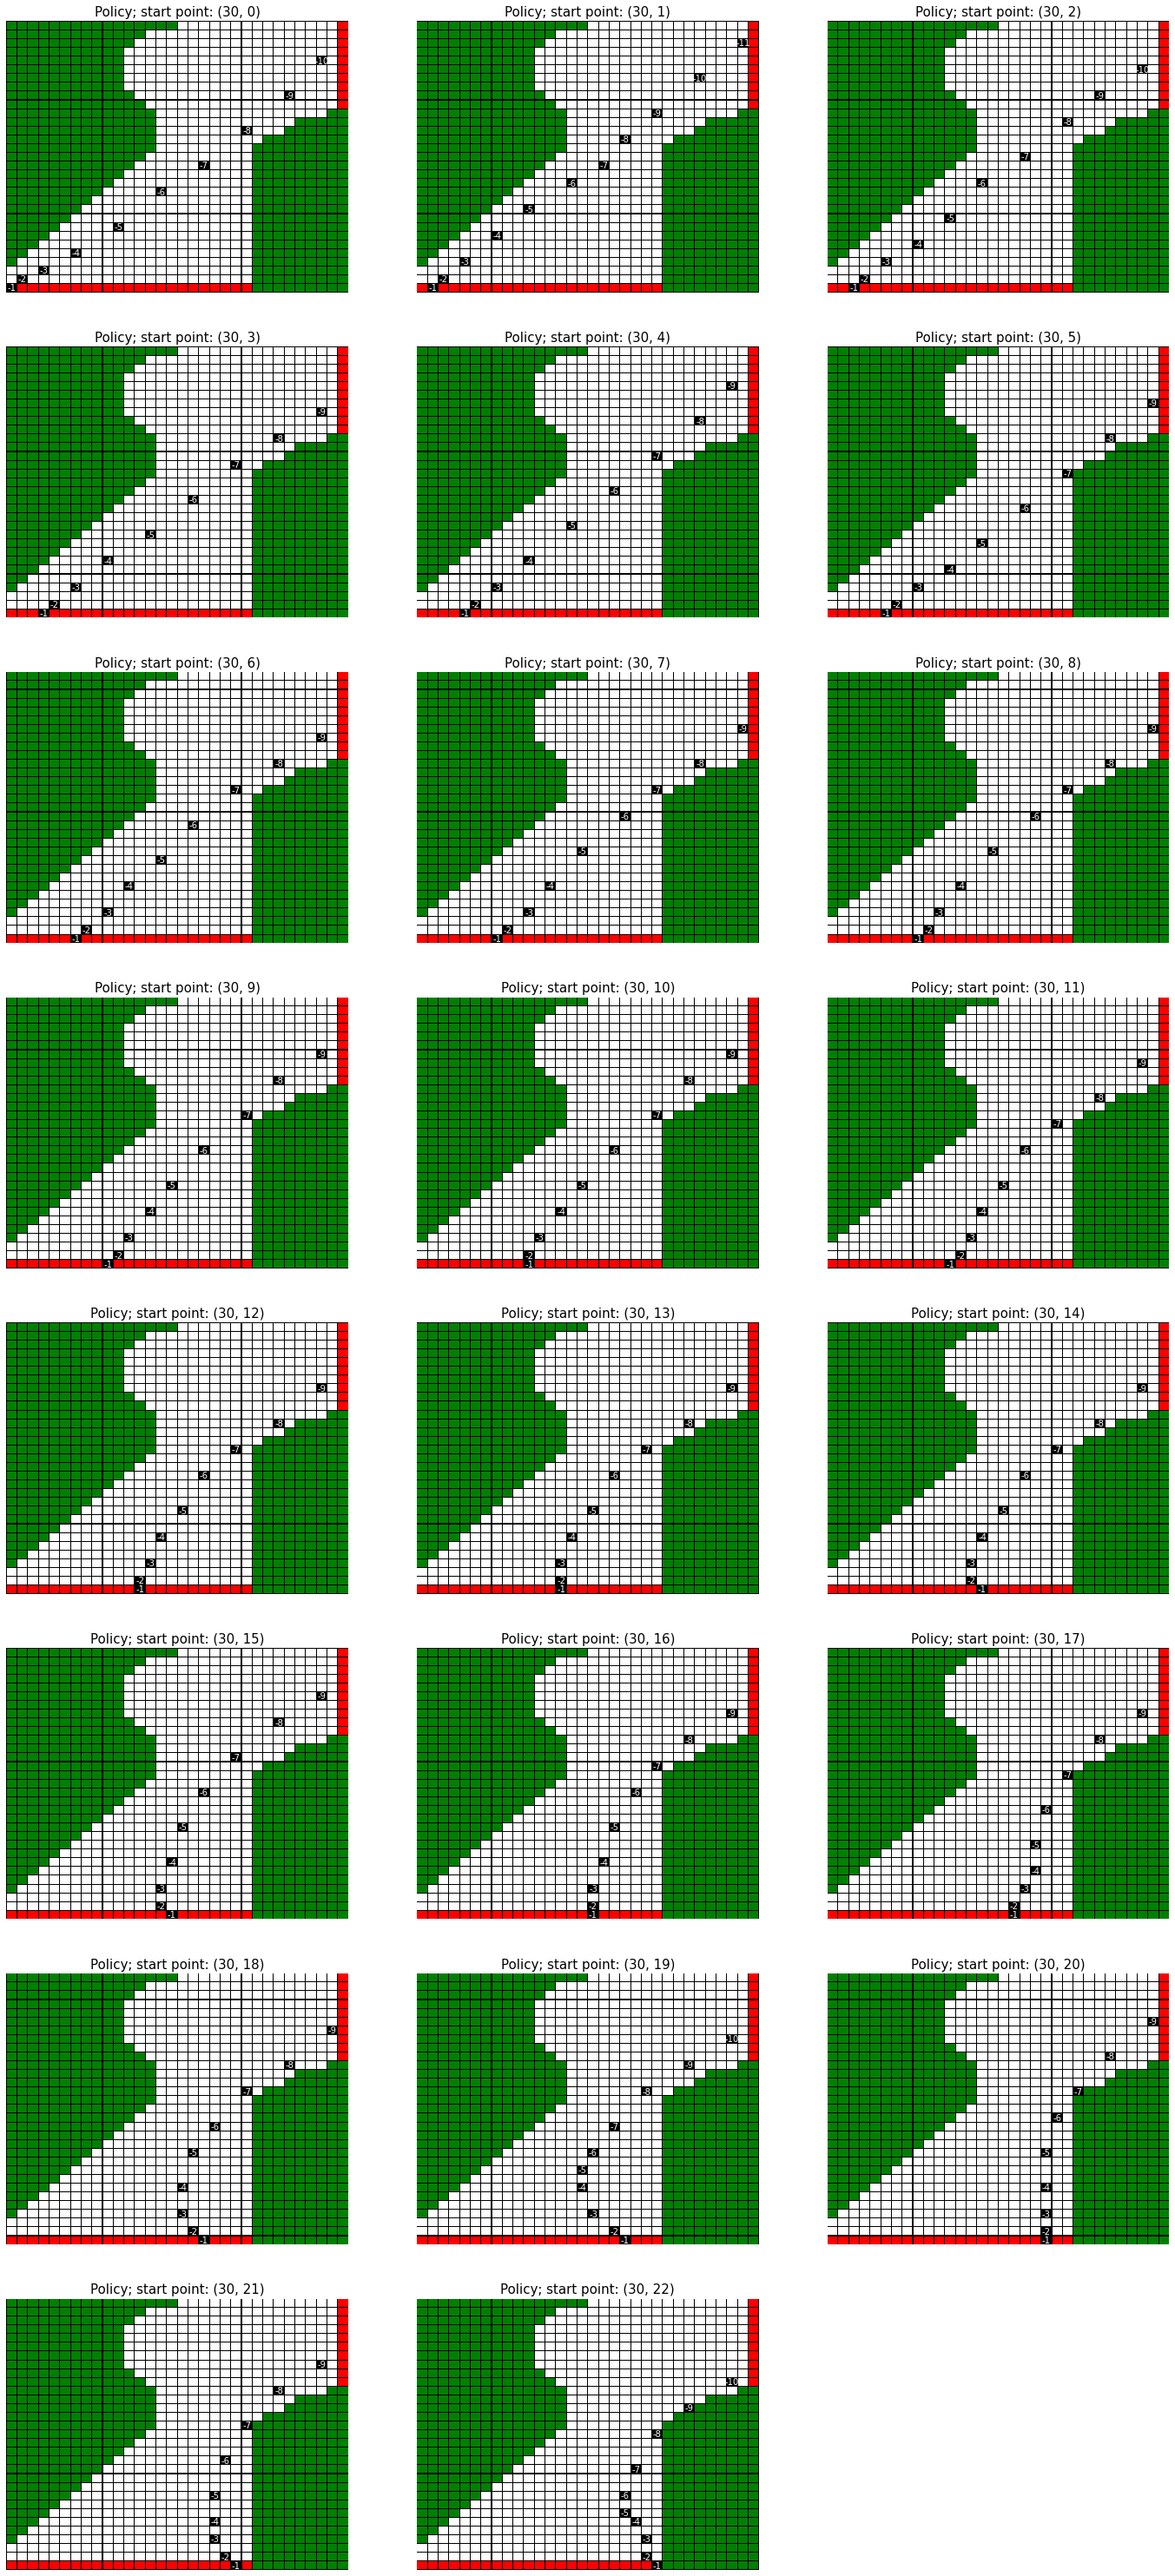

In [20]:
TD = Racetrack(100000, Turn_Matrix, Type= 'Sarsa', gamma = .99, alpha = .1, 
               eps = .2, n_steps = 3, figsize = (24,54))

# Q-Learning

Starting iteration number: 1
Average lenth of episodes for iterations in [1 ... 50000]: 35.01474 
 epsilon: 0.2 
 done in: 145.6947751045227 seconds 

Starting iteration number: 50001
Ended in 206.38927125930786 seconds


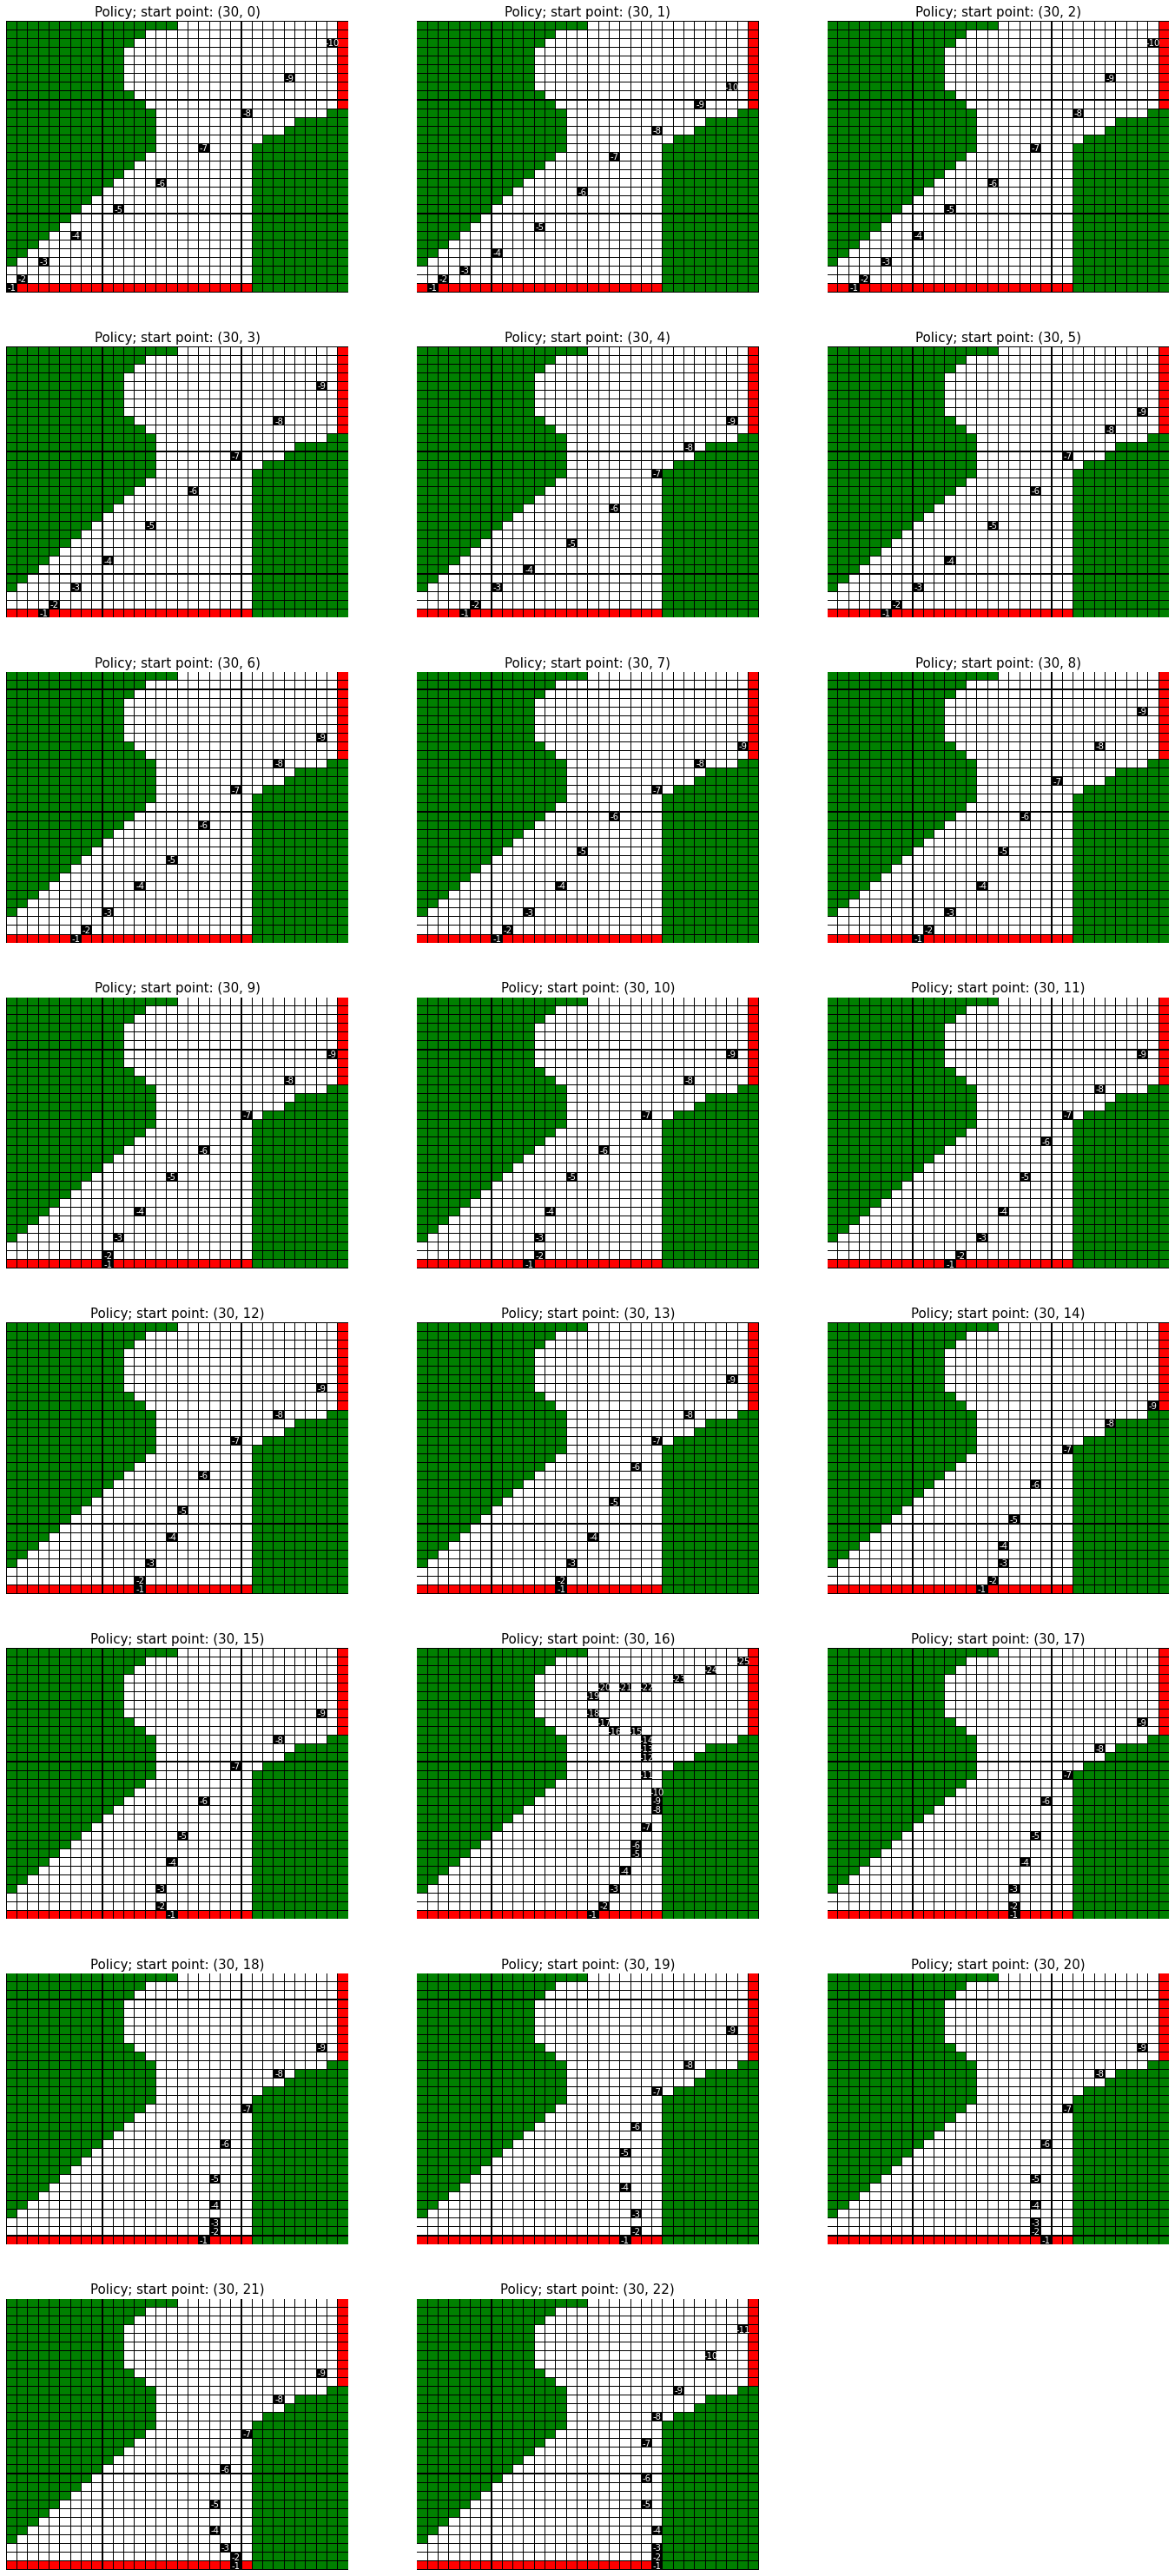

In [21]:
TD = Racetrack(100000, Turn_Matrix, Type= 'Q-learning', gamma = .99, alpha = .1, 
               eps = .2, n_steps = 3, figsize = (24,54))

# Expected Sarsa

Starting iteration number: 1
Average lenth of episodes for iterations in [1 ... 50000]: 35.08956 
 epsilon: 0.2 
 done in: 154.69909477233887 seconds 

Starting iteration number: 50001
Ended in 220.79036474227905 seconds


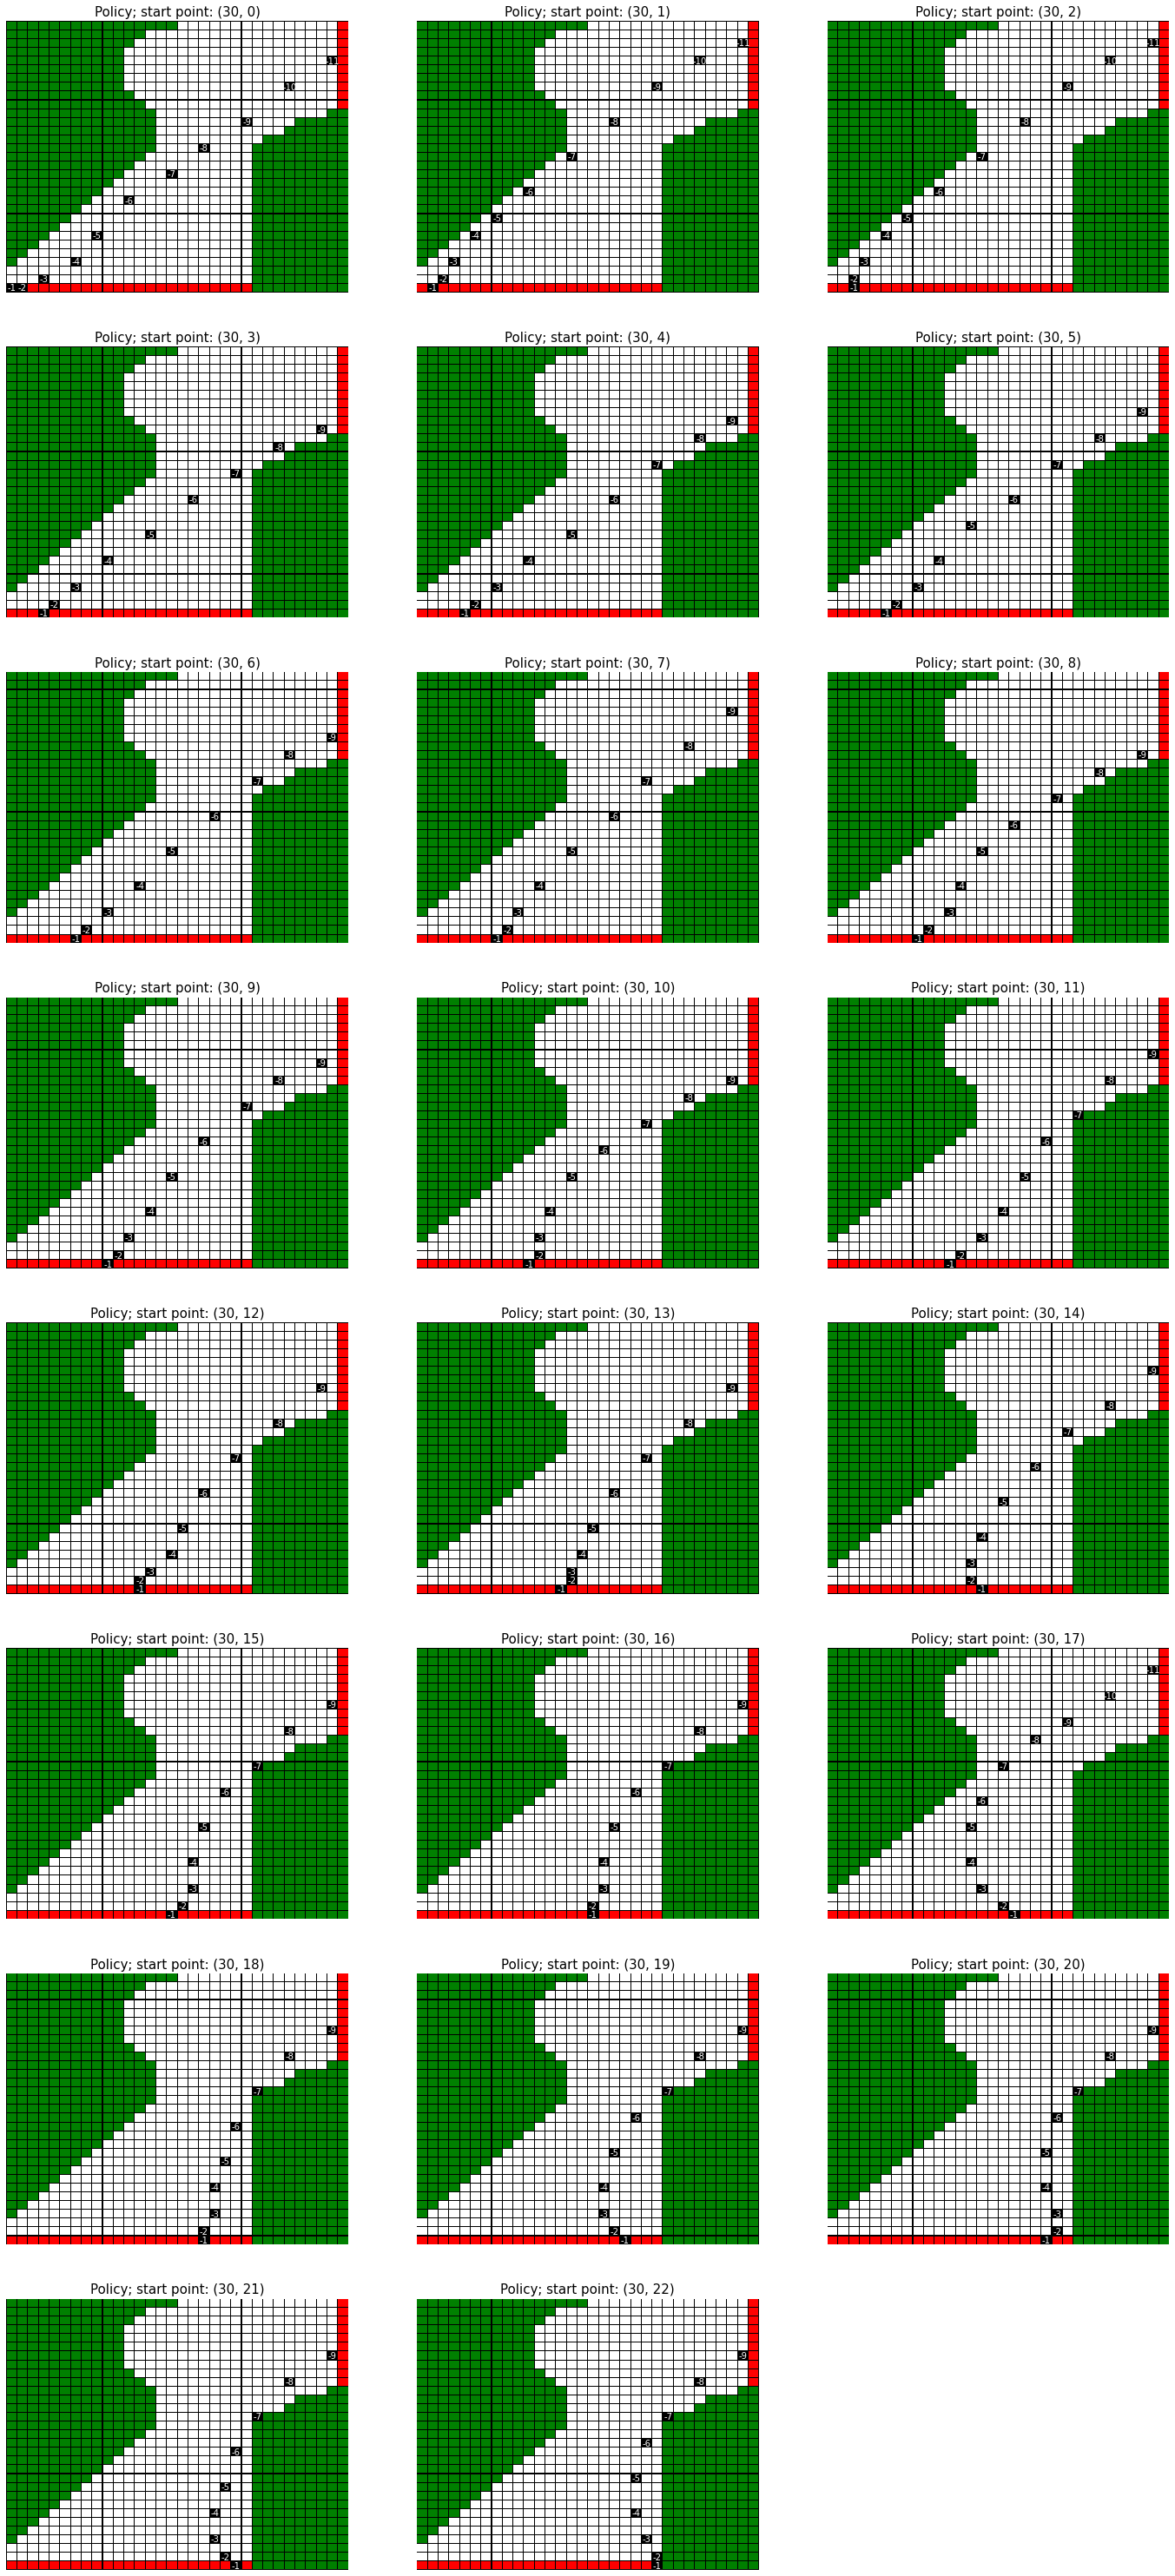

In [22]:
TD = Racetrack(100000, Turn_Matrix, Type= 'Expected-Sarsa', gamma = .99, alpha = .1, 
               eps = .2, n_steps = 3, figsize = (24,54))